Artsnavn

In [1]:

import pandas as pd
url = "https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=-1&includeSynonyms=true&includeVernacularNames=true&exportType=Csv"
biota =pd.read_csv(url, sep = ";", na_values = "NaN",dtype ="str")
#url = 'https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=99480&includeSynonyms=true&includeVernacularNames=true&exportType=Csv'
#'blob:https://nortaxa.artsdatabanken.no/3f6d6c4f-5312-4d12-8624-a99c2272afb8'


In [2]:
display(biota)

,VernacularNameBokmaal,StatusBokmaal,ReferenceBokmaal,CommentBokmaal,ValidFromBokmaal,VernacularNameNynorsk,StatusNynorsk,ReferenceNynorsk,CommentNynorsk,ValidFromNynorsk,...,PresentationName,Rank,TaxonomicStatus,NomenclaturalStatuses,NameString,Author,Reference,ValidFrom,Comment,ExistsInNorway
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Biota,Sphere,Accepted,NaN,Biota,NaN,NaN,01.01.2008,Biota,False
1,dyreriket,Preferred,CatalogueOfLife2008rev,NaN,07.02.2012,dyreriket,Preferred,NaN,NaN,07.02.2012,...,Animalia,Kingdom,Accepted,NaN,Animalia,NaN,CatalogueOfLife2008rev,30.04.2009,"Importert fra ""Catalogue of Life""",False
2,erkebakterier,Preferred,NaN,NaN,02.02.2012,NaN,NaN,NaN,NaN,NaN,...,Archaea,Kingdom,Accepted,NaN,Archaea,NaN,CatalogueOfLife2008rev,30.04.2009,"Importert fra ""Catalogue of Life""",False
3,bakterier,Preferred,NaN,NaN,02.02.2012,NaN,NaN,NaN,NaN,NaN,...,Bacteria,Kingdom,Accepted,NaN,Bacteria,NaN,CatalogueOfLife2008rev,30.04.2009,"Importert fra ""Catalogue of Life""",False
4,det gule riket,Preferred,CatalogueOfLife2008rev,NaN,02.02.2012,det gule riket,Preferred,NaN,NaN,02.02.2012,...,Chromista,Kingdom,Accepted,NaN,Chromista,Caval.-Sm.,NaN,30.04.2009,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Moniliformida,Order,Accepted,NaN,Moniliformida,NaN,CatalogueOfLife2008rev,30.04.2009,"Importert fra ""Catalogue of Life""",False
226045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Oligacanthorhynchida,Order,Accepted,NaN,Oligacanthorhynchida,NaN,CatalogueOfLife2008rev,30.04.2009,"Importert fra ""Catalogue of Life""",False
226046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Oligacanthorhynchidae,Family,Accepted,NaN,Oligacanthorhynchidae,NaN,NaN,08.11.2012,NaN,False
226047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Macracanthorhynchus,Genus,Accepted,NaN,Macracanthorhynchus,NaN,NaN,08.11.2012,NaN,False


In [22]:

import pandas as pd
url = 'https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=99480&includeSynonyms=true&includeVernacularNames=true&exportType=Csv'
#url = "https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=-1&includeSynonyms=true&includeVernacularNames=true&exportType=Csv"
biota =pd.read_csv(url, sep = ";", na_values = "NaN",dtype ="str")
biota



,VernacularNameBokmaal,StatusBokmaal,ReferenceBokmaal,CommentBokmaal,ValidFromBokmaal,VernacularNameNynorsk,StatusNynorsk,ReferenceNynorsk,CommentNynorsk,ValidFromNynorsk,VernacularNameNordSamisk,StatusNordSamisk,ReferenceNordSamisk,CommentNordSamisk,ValidFromNordSamisk,Sphere,Kingdom,Subkingdom,Phylum,Subphylum,Superclass,Class,Subclass,Infraclass,Superorder,Order,Suborder,Infraorder,Superfamily,Family,Subfamily,Tribe,Genus,Subgenus,Section,Species,Subspecies,Variety,Form,TaxonId,ScientificNameId,ParentScientificNameId,AcceptedScientificNameId,PresentationName,Rank,TaxonomicStatus,NomenclaturalStatuses,NameString,Author,Reference,ValidFrom,Comment,ExistsInNorway
0,orkidéfamilien,Preferred,NaN,NaN,13.09.2009,orkidéfamilien,Preferred,NaN,NaN,13.09.2009,orkidea,Preferred,NaN,NaN,30.04.2018,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59440,99480,1286,99480,Orchidaceae,Family,Accepted,NaN,Orchidaceae,Juss.,NaN,20.08.2009,NaN,False
1,narrmarihandslekta,Preferred,NaN,NaN,13.09.2009,narrmarihandslekta,Preferred,NaN,NaN,13.09.2009,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Anacamptis,NaN,NaN,NaN,NaN,NaN,NaN,59441,99481,99480,99481,Anacamptis,Genus,Accepted,NaN,Anacamptis,Rich.,NaN,20.08.2009,NaN,False
2,skogfrueslekta,Preferred,NaN,NaN,13.09.2009,skogfrueslekta,Preferred,NaN,NaN,13.09.2009,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Cephalanthera,NaN,NaN,NaN,NaN,NaN,NaN,59443,99483,99480,99483,Cephalanthera,Genus,Accepted,NaN,Cephalanthera,Rich.,NaN,20.08.2009,NaN,False
3,fjellkurleslekta,Preferred,NaN,NaN,13.09.2009,fjellkurleslekta,Preferred,NaN,NaN,13.09.2009,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Chamorchis,NaN,NaN,NaN,NaN,NaN,NaN,59446,99486,99480,99486,Chamorchis,Genus,Accepted,NaN,Chamorchis,Rich.,NaN,20.08.2009,NaN,False
4,grønnkurleslekta,Preferred,NaN,NaN,13.09.2009,grønkurleslekta,Preferred,NaN,NaN,13.09.2009,váksi,Preferred,NaN,NaN,30.04.2018,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Coeloglossum,NaN,NaN,NaN,NaN,NaN,NaN,59448,99488,99480,99488,Coeloglossum,Genus,Accepted,NaN,Coeloglossum,Hartm.,NaN,20.08.2009,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,stor skogfrue,Preferred,NaN,NaN,03.07.2018,stor skogfrue,Preferred,NaN,NaN,03.07.2018,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Cephalanthera,NaN,NaN,pallens,NaN,NaN,NaN,131614,155956,99483,155952,Cephalanthera pallens,Species,Synonym,NaN,pallens,Rich.,NaN,25.06.2016,NaN,True
376,narrmarihand,Preferred,NaN,NaN,13.09.2009,narrmarihand,Preferred,NaN,NaN,13.09.2009,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Anacamptis,NaN,NaN,morio,NaN,NaN,NaN,130297,99482,99481,99482,Anacamptis morio,Species,Accepted,NaN,morio,"(L.) R.M.Bateman, Pridgeon & M.W.Chase",NaN,24.06.2016,NaN,True
377,salepsrot,Preferred,NaN,NaN,03.07.2018,salepsrot,Preferred,NaN,NaN,03.07.2018,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Anacamptis,NaN,NaN,pyramidalis,NaN,NaN,NaN,130298,154318,99481,154318,Anacamptis pyramidalis,Species,Accepted,NaN,pyramidalis,(L.) Rich.,NaN,24.06.2016,NaN,False
378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Monocots,NaN,NaN,NaN,Asparagales,NaN,NaN,NaN,Orchidaceae,NaN,NaN,Anacamptis,NaN,NaN,laxiflora,NaN,NaN,N

In [4]:
#biota[pd.notna(biota['Species'])]
biota['Species']

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
226044             NaN
226045             NaN
226046             NaN
226047             NaN
226048    hirudinaceus
Name: Species, Length: 226049, dtype: object

## Rødlista

In [19]:

import pandas as pd
artsnavnebase = "https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=-1&includeSynonyms=true&includeVernacularNames=true&exportType=Csv"
artsnavnebase =pd.read_csv(artsnavnebase, sep = ";")
artsnavnebase.head

C:\Users\endofs\AppData\Local\Temp\ipykernel_22600\4147161154.py:3: DtypeWarning: Columns (7,8,12,19,20,22,23,24,26,27,28,30,31,33,34,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  artsnavnebase =pd.read_csv(artsnavnebase, sep = ";")


<bound method NDFrame.head of        VernacularNameBokmaal StatusBokmaal        ReferenceBokmaal  \
0                        NaN           NaN                     NaN   
1                  dyreriket     Preferred  CatalogueOfLife2008rev   
2              erkebakterier     Preferred                     NaN   
3                  bakterier     Preferred                     NaN   
4             det gule riket     Preferred  CatalogueOfLife2008rev   
...                      ...           ...                     ...   
226044                   NaN           NaN                     NaN   
226045                   NaN           NaN                     NaN   
226046                   NaN           NaN                     NaN   
226047                   NaN           NaN                     NaN   
226048                   NaN           NaN                     NaN   

       CommentBokmaal ValidFromBokmaal VernacularNameNynorsk StatusNynorsk  \
0                 NaN              NaN             

# Nettverksanalyser

In [1]:
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics.pairwise import euclidean_distances
def distanceMatrix(xy):
    return(squareform(pdist(xy)))

In [2]:
distanceMatrix(pos)

NameError: name 'pos' is not defined

In [5]:
# load packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import arcpy
import os
import scipy as scipy
import pandas as pd
from scipy.linalg import eig
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances


pd.set_option('display.max_columns', None)
np.set_printoptions(precision=20)

# Function to calculate distances, both Euclidian and "realised"/"Experienced" distances, where the latter is a probability output
def calculate_distance_matrix(input_feature_class, Alpha = 1/1000, ExportLines = False):
    """
    This function calculates a distance matrix for all points in the input feature class using NumPy arrays.
    
    :param input_feature_class: Path to the input feature class containing point geometries.
    :return: A NumPy array representing the distance matrix.
    """
    # Retrieve the spatial reference of the input feature class.
    sr = arcpy.Describe(input_feature_class).spatialReference

    # Get the number of points in the input feature class.
    point_count = int(arcpy.GetCount_management(input_feature_class).getOutput(0))

    # Initialize a NumPy array to store the distance matrix with zeros.
    distance_matrix = np.zeros((point_count, point_count))
    # Initialize a NumPy array to store the dispersal probabilities.
    distance_matrix_exp = np.zeros((point_count, point_count))

    # Create a list to store geometries and their IDs.
    geometries = []    
    
    # Here we have chunk where we create a feature class where we can store the lines going btw all the features
    # Define the spatial reference
    spatial_ref = arcpy.Describe(input_feature_class).spatialReference
    
    # Use a search cursor to iterate through the features and store geometries.
    with arcpy.da.SearchCursor(input_feature_class, ["OID@", "SHAPE@"], spatial_reference=sr) as cursor:
        for row in cursor:
            oid, geom = row
            geometries.append((oid, geom))

    # Calculate distances and fill the NumPy array.
    for i, (oid_from, geom_from) in enumerate(geometries):
        #print(i)
        for j, (oid_to, geom_to) in enumerate(geometries):
            if oid_from != oid_to:  # Ensure that we don't calculate the distance to the same feature.
                distance = geom_from.distanceTo(geom_to)  # Calculate the distance to another feature.
                distance_matrix[i, j] = distance  # Store the calculated distance in the array.
                distance_matrix_exp[i, j] = np.exp(-distance*Alpha)  # Store the calculated distance in the array.
                #if ExportLines is True
                    # Create a new feature class
                    #new_feature_class = 'Paths'
                    #arcpy.CreateFeatureclass_management(arcpy.env.workspace, new_feature_class, 'POLYLINE', spatial_reference=spatial_ref)
                    #start_point = geom_from.centroid # now we move over to generating lines btw all the geometries
                #    end_point = geom_to.centroid  #  this lines are later used to illustrate sensitities of the connections
                #    line = arcpy.Polyline(arcpy.Array([start_point, end_point]), spatial_ref) # create a line
                #    # TODO: Add OID
                #    # Use an insert cursor to add the new line to the feature class
                #    with arcpy.da.InsertCursor(new_feature_class, ['SHAPE@']) as cursor:
                #        cursor.insertRow([line])

    return distance_matrix, distance_matrix_exp  # Return the complete distance matrix.

def calculate_areas_and_outer_matrix(feature_class):
    """
    Calculate the areas of features in a feature class and the outer product matrix of these areas.
    
    :param feature_class: Path to the input feature class.
    :return: A tuple containing a list of areas and the outer product matrix.
    """
    # Step 1: Extract Areas
    areas = []
    with arcpy.da.SearchCursor(feature_class, ["SHAPE@AREA"]) as cursor:
        for row in cursor:
            areas.append(row[0])  # Append the area of the feature to the list

    # Step 2: Create Outer Matrix
    areas_array = np.array(areas)  # Convert the list of areas to a NumPy array
    outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix

    return areas, outer_matrix

# Main function
def CalcEigenmeasures(LandscapeMatrix):
    # Define the function to calculate contribution
    def calculate_contribution(Lambda, Mij):
        num_patches = Mij.shape[0]
        contributions = np.zeros(num_patches)
        
        for ii in range(num_patches):
            # Exclude the ii-th row and column from Mij
            Mij_sub = np.delete(Mij, ii, axis=0)
            Mij_sub = np.delete(Mij_sub, ii, axis=1)
            
            # Calculate the largest eigenvalue of the modified Mij
            eigenvalues = np.linalg.eigvals(Mij_sub)
            largest_eigenvalue = np.max(eigenvalues)
            
            # Calculate the contribution
            contributions[ii] = (Lambda - largest_eigenvalue) / Lambda
        
        return contributions

    eigenvalues, eigenvectors = scipy.linalg.eig(Mij)
    Le = np.argmax(eigenvalues)
    Lambda = np.real(eigenvalues[Le])
    
    # Approximate stable age distribution = right eigenvector
    w0 = np.real(eigenvectors[:, Le])
    w = np.abs(w0)
    # Reproductive value = left eigenvector
    # This equals the right eigenvector of the landscape matrix transposed
    V = np.linalg.inv(eigenvectors).conj()
    v = np.abs(np.real(V[Le, ]))
    
    # Contribution of the patch to lambda
    # When considering small perturbations, loses a small part of the habitats and habitat degradation
    pc = v.T * w# # These are normalized
    #pc_small = pc / np.sum(pc)  # Normalize the contributions

    # 'pc_s' now contains the normalized contribution of each patch to lambda
    # Call the function with your Lambda and Mij data
    contributions = calculate_contribution(Lambda, Mij)

    # Collect all the measures
    EigenMeasures = pd.DataFrame({"NiNID":ids,
                                  "PC_small":pc,
                                  "PC_large":contributions,
                                  "REv":w, 
                                  "LEv":v}, index = names)
    return EigenMeasures

def communities(landscape_matrix):
    # Convert the input matrix to a NumPy array
    M = np.array(landscape_matrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        print(t)
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]


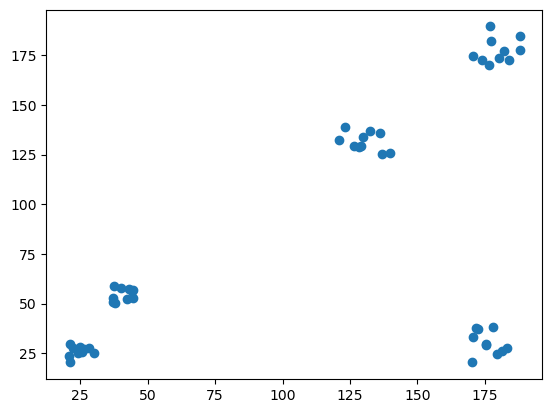

In [7]:
# Generate random positions
pos = np.vstack([
    np.column_stack((np.random.uniform(20, 30, 10), np.random.uniform(20, 30, 10))),
    np.column_stack((np.random.uniform(35, 45, 10), np.random.uniform(50, 60, 10))),
    np.column_stack((np.random.uniform(170, 190, 10), np.random.uniform(170, 190, 10))),
    np.column_stack((np.random.uniform(170, 190, 10), np.random.uniform(20, 40, 10))),
    np.column_stack((np.random.uniform(120, 140, 10), np.random.uniform(120, 140, 10)))
])

# Plot the positions
plt.scatter(pos[:, 0], pos[:, 1])
plt.show()

# Calculate the distance matrix
M = squareform(pdist(pos))

# Apply the exponential transformation
M0 = np.exp(-M * (1/30))

# Set the diagonal to zero
np.fill_diagonal(M0, 0)

In [22]:
results = communities(M0)
print(results.shape[1])

Run loop
0
1
2
4


In [17]:
sizes = np.random.uniform(4, 30, len(M0))
# Step 2: Create Outer Matrix
areas_array = sizes
outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix
dists = distanceMatrix(pos)
realizedDists = np.exp(-dists*.5)
Mij = realizedDists*outer_matrix
# set diagonal to zero
np.fill_diagonal(Mij, 0)
Mij

array([[0.0000000000000000e+00, 2.3972641038125202e+00,
        4.6388634417406124e+01, ..., 2.4655811390857039e-29,
        8.7809972872840062e-32, 7.5636048561070240e-33],
       [2.3972641038125202e+00, 0.0000000000000000e+00,
        1.8291801597590826e+01, ..., 8.5708313372409254e-31,
        3.6441952126764981e-33, 2.8351224247036947e-34],
       [4.6388634417406124e+01, 1.8291801597590826e+01,
        0.0000000000000000e+00, ..., 1.6328988761595165e-29,
        6.3522961291672950e-32, 5.2075351801504403e-33],
       ...,
       [2.4655811390857039e-29, 8.5708313372409254e-31,
        1.6328988761595165e-29, ..., 0.0000000000000000e+00,
        5.6945238631159485e-03, 3.9805034370527806e-02],
       [8.7809972872840062e-32, 3.6441952126764981e-33,
        6.3522961291672950e-32, ..., 5.6945238631159485e-03,
        0.0000000000000000e+00, 1.1027156543491426e-01],
       [7.5636048561070240e-33, 2.8351224247036947e-34,
        5.2075351801504403e-33, ..., 3.9805034370527806e-02,
 

C:\Users\endofs\AppData\Local\Temp\ipykernel_15388\1687202695.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0, 0].scatter(pos[:, 0], pos[:, 1], cmap='viridis')


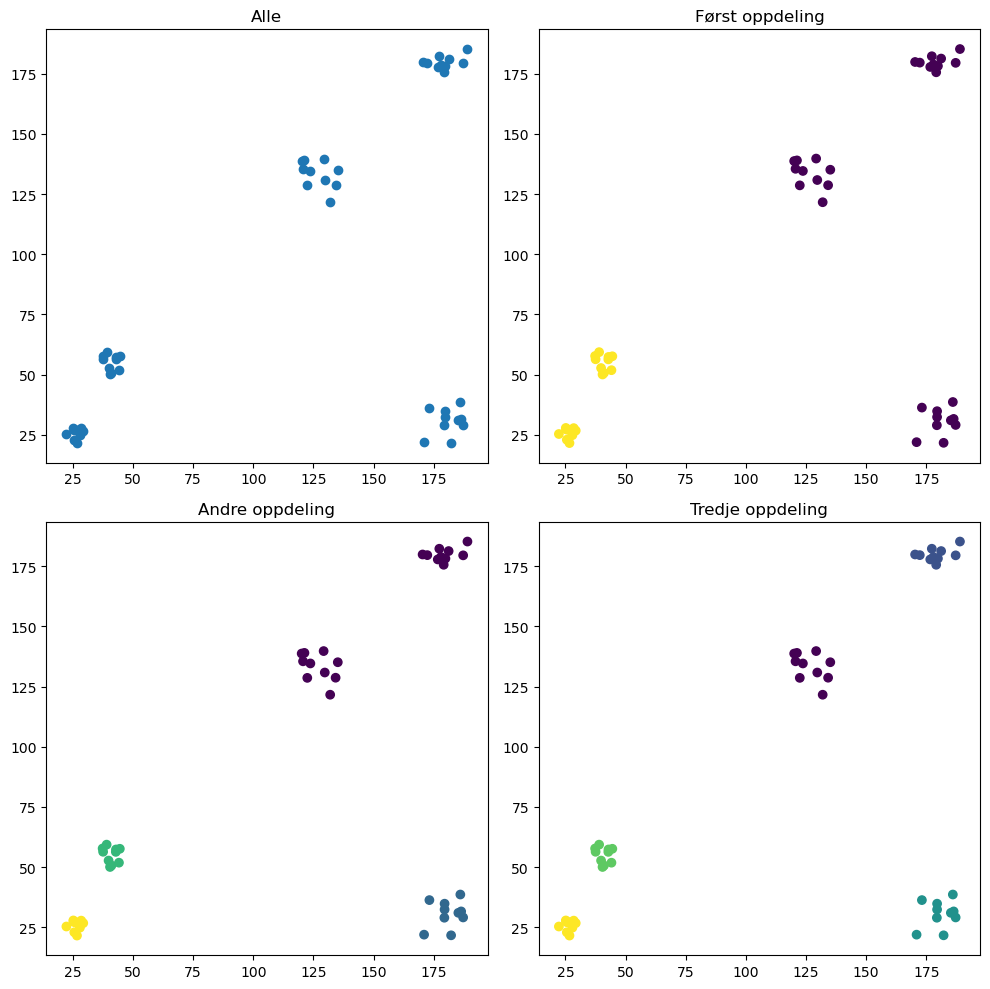

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each scatter plot in its respective subplot
axs[0, 0].scatter(pos[:, 0], pos[:, 1], cmap='viridis')
axs[0, 0].set_title('Alle')

axs[0, 1].scatter(pos[:, 0], pos[:, 1], c=results[:,1], cmap='viridis')
axs[0, 1].set_title('Først oppdeling')

axs[1, 0].scatter(pos[:, 0], pos[:, 1], c=results[:,2], cmap='viridis')
axs[1, 0].set_title('Andre oppdeling')

axs[1, 1].scatter(pos[:, 0], pos[:, 1], c=results[:,3], cmap='viridis')
axs[1, 1].set_title('Tredje oppdeling')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [31]:
squareform(pdist(pos))

array([[  0.                ,   1.331691948708701 ,   5.615101297786634 ,
        ..., 143.16825504670982  , 144.50433264516656  ,
        146.19366227211833  ],
       [  1.331691948708701 ,   0.                ,   5.3094535693941   ,
        ..., 143.37982731984485  , 144.65221006807516  ,
        146.29861151848607  ],
       [  5.615101297786634 ,   5.3094535693941   ,   0.                ,
        ..., 148.68203909892324  , 149.96160201425226  ,
        151.60612564807428  ],
       ...,
       [143.16825504670982  , 143.37982731984485  , 148.68203909892324  ,
        ...,   0.                ,   7.0688797722898995,
         12.045027674982288 ],
       [144.50433264516656  , 144.65221006807516  , 149.96160201425226  ,
        ...,   7.0688797722898995,   0.                ,
          4.995340631686898 ],
       [146.19366227211833  , 146.29861151848607  , 151.60612564807428  ,
        ...,  12.045027674982288 ,   4.995340631686898 ,
          0.                ]])

In [39]:
for i in (10, 100-1):
    ...:     %timeit dfdist(pos)
print("dsd")
for i in (10, 100-1):
    ...:     %timeit euclidean_distances(pos, pos)

print("dsd")



9.82 µs ± 370 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
10.3 µs ± 353 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
dsd
65.9 µs ± 878 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
64.7 µs ± 301 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
dsd
